# LIBRARY IMPORTS

In [1]:
#Importing all the necessary libraries required
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from string import ascii_letters
import datetime
import pygeohash as gh

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

import folium
from folium.plugins import HeatMap
from folium import plugins

from sklearn.base import clone

from math import sqrt
from math import log
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.ensemble.forest import ExtraTreesClassifier
from sklearn.ensemble.bagging import BaggingClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.tree.tree import DecisionTreeClassifier
from sklearn.tree.tree import ExtraTreeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

%matplotlib inline

/Users/Raghav/.asdf/installs/python/3.6.9/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# READING THE DATA

In [2]:
#Reading the csv
data = pd.read_csv("ct_rr.csv")

/Users/Raghav/.asdf/installs/python/3.6.9/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng
0,2018-04-07 07:07:17,14626,12.313621,76.658195,12.287301,76.602280
1,2018-04-07 07:32:27,85490,12.943947,77.560745,12.954014,77.543770
2,2018-04-07 07:36:44,05408,12.899603,77.587300,12.934780,77.569950
3,2018-04-07 07:38:00,58940,12.918229,77.607544,12.968971,77.636375
4,2018-04-07 07:39:29,05408,12.899490,77.587270,12.934780,77.569950


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8381556 entries, 0 to 8381555
Data columns (total 6 columns):
ts          object
number      object
pick_lat    float64
pick_lng    float64
drop_lat    float64
drop_lng    float64
dtypes: float64(4), object(2)
memory usage: 383.7+ MB


In [5]:
data.describe()

,pick_lat,pick_lng,drop_lat,drop_lng
count,8.381556e+06,8.381556e+06,8.381556e+06,8.381556e+06
mean,1.301024e+01,7.762875e+01,1.301084e+01,7.760709e+01
std,9.032779e-01,4.490899e-01,9.516462e-01,1.475269e+00
min,-4.877217e+01,-9.395859e+01,-5.794684e+01,-1.278179e+02
25%,1.291638e+01,7.759511e+01,1.291627e+01,7.759272e+01
50%,1.293741e+01,7.761597e+01,1.293895e+01,7.761737e+01
75%,1.297118e+01,7.764515e+01,1.297307e+01,7.764706e+01
max,6.769665e+01,9.281412e+01,6.152401e+01,1.748860e+02


# EXPLORATORY DATA ANALYSIS

Let's see what all information we can get from our data.

The following cell shows how many customers are frequent ride requesters and how many customers are rare users.

In [6]:
data['number'].value_counts()

83997    2603
64053    2011
10711    1891
13083    1768
43330    1656
89511    1646
19983    1589
93037    1544
1149     1538
79064    1538
79121    1536
94569    1531
62796    1458
89444    1456
61577    1443
91402    1441
37385    1441
33836    1438
52440    1422
79104    1411
4229     1403
39461    1386
1498     1384
79487    1376
47002    1373
31651    1371
47460    1364
14092    1362
86424    1360
61411    1356
         ... 
73057       1
72988       1
12476       1
67743       1
12475       1
76924       1
72775       1
72804       1
79366       1
72812       1
12460       1
72822       1
39042       1
12457       1
46326       1
72848       1
72849       1
72859       1
72865       1
50952       1
32936       1
72894       1
44148       1
01440       1
12428       1
72955       1
27321       1
72961       1
72962       1
36694       1
Name: number, Length: 170392, dtype: int64

We can see that there are some users who have a high ride request count in the past year, and some which have as low as 1 ride request. This means our data has both frequent customers as well as rare users. Frequent customers will help identify trends in ride requests, whereas rare users could help identify HOTSPOTS in areas. Thus we should definitely look at trend analysis and spatial analysis.

Removing all data points with customer number as None

In [7]:
data = data[data['number']!=' None']

Some data points lied outside India. These are outliers. If location of a data point is out of India, that data point needs to be removed. The border latitudes and longitudes of India have been used to identify outliers. Longitude Border = (68, 98) and Latitude Border = (8, 38)

In [8]:
data = data[data['pick_lat'] <= 38] 
data = data[data['pick_lat']>=8] 
data = data[data['pick_lng'] <= 98] 
data = data[data['pick_lng'] >= 68] 

USING THE MAP TO UNDERSTAND THE AREA DISTRIBUTION OF RIDE REQUESTS

In [9]:
#A Function to generate the BaseMap using the Folium library
def generateBaseMap(default_location=[21, 79], default_zoom_start=4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

Generating BaseMap of India's Centre (Nagpur)

In [10]:
basemap = generateBaseMap()
basemap

VISUALIZING THE HEATMAP OF REQUESTS


******NOTE******
- Ideally the heatmap should be made for the whole data,
but since I'm constrained with computational power, it is not possible to do so,
hence only the first 20,0000 datapoints have been taken into consideration.

In [11]:
data_n = data[:20000]

Next, we plot a heatmap of the number of data points we have in each area. This tells us which area has high ride requests and which area has low requests.


In [12]:
d = data_n[['pick_lat', 'pick_lng']].as_matrix()

basemap.add_children(plugins.HeatMap(d, radius=15))
basemap

/Users/Raghav/.asdf/installs/python/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/Raghav/.asdf/installs/python/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


As we can see, with the 1st 20,000 data points, Bangalore dominates the number of requests compared to other cities. But this is not a true representation, since we have taken only the first 20,000 datapoints. If you zoom in further into Bangalore, you notice which areas in Bangalore have higher requests than others. These heatmaps can help identify 'HOTSPOTS' in a city, and a comparative analysis can be done of 'HOTSPOTS' on weekdays vs weekends.

CORRELATION PLOT

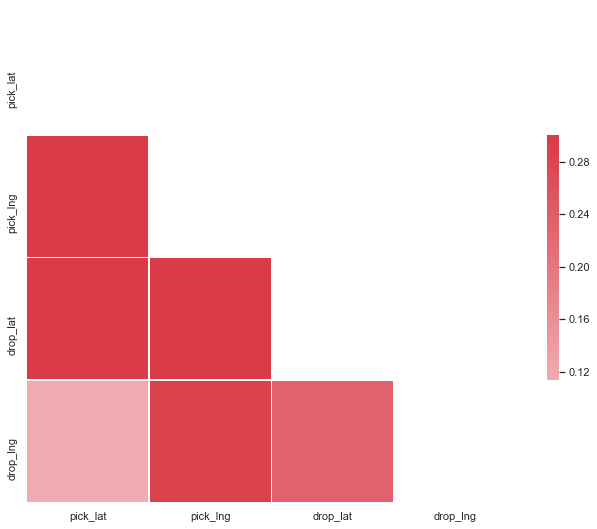

In [13]:
#Using the seaborn library for a correlation plot

#Creating a correlation plot
sns.set(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, n = 10,as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Correlation Plot doesn't yield much insights in this case.

# FEATURE ENGINEERING AND DATA VISUALIZATIONS

We want to identify important features of the data, which we can use in our model, to help us predict future ride request times.

Let's start with using the TimeStamp information we have. We first get the timestamp into the right format, to use it further to extract important features from it. We want to capture various trends in the data, which might help our modeling. For example, Hourly Trends, Weekly trends, Monthly Trends. These could be used as features for prediction.

In [14]:
data['ts'] = pd.to_datetime(data['ts'], format="%Y/%m/%d %H:%M:%S")
data['ts'] = pd.to_datetime(data['ts'], errors='coerce')

Extracting Hour of the Day feature from the timestamp.

In [15]:
data['HourOfDay'] = data['ts'].dt.hour

Extracting Day of the Week feature from the timestamp.

In [16]:
data['DayOfWeekNum'] = data['ts'].dt.dayofweek
data['DayOfWeek'] = data['ts'].dt.weekday_name

Extracting Month of the Year feature from the timestamp.

In [17]:
data['Month'] = data['ts'].dt.month

Extracting Day of the Month feature from the timestamp.

In [18]:
data['MonthDayNum'] = data['ts'].dt.day

These were the features extracted from timestamp. Now let's extract some features from the Latitude and Longitude Information. Partitioning the geographical space of India into clusters is important as we want to predict over a cluster and not points in space. Cluster Aggregations make more sense than points, since a user might not always book a ride from an exact latitude and longitude in space. Hence Cluster formation is important. For forming clusters, the GeoHash library is used.
The clusters are then used as features. The clusters will replace the individual latitude and longitude features later while making a model.

In [19]:
data['geohash_pick']=data.apply(lambda x: gh.encode(x.pick_lat, x.pick_lng, precision=5), axis=1)
data['geohash_drop']=data.apply(lambda x: gh.encode(x.drop_lat, x.drop_lng, precision=5), axis=1)

In [20]:
data.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,HourOfDay,DayOfWeekNum,DayOfWeek,Month,MonthDayNum,geohash_pick,geohash_drop
0,2018-04-07 07:07:17,14626,12.313621,76.658195,12.287301,76.602280,7,5,Saturday,4,7,tdnw0,tdnmz
1,2018-04-07 07:32:27,85490,12.943947,77.560745,12.954014,77.543770,7,5,Saturday,4,7,tdr1s,tdr1s
2,2018-04-07 07:36:44,05408,12.899603,77.587300,12.934780,77.569950,7,5,Saturday,4,7,tdr1m,tdr1t
3,2018-04-07 07:38:00,58940,12.918229,77.607544,12.968971,77.636375,7,5,Saturday,4,7,tdr1q,tdr1y
4,2018-04-07 07:39:29,05408,12.899490,77.587270,12.934780,77.569950,7,5,Saturday,4,7,tdr1m,tdr1t


Lets visualize the information given by our new features that we've created now!

# Hourly Trend in a Day

Lets start with the Hourly Trend of Ride Requests within a Day.

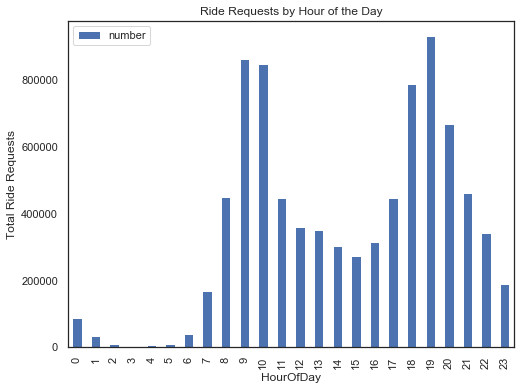

In [21]:
hour = data.pivot_table(index=['HourOfDay'],
                                  values='number',
                                  aggfunc='count')
hour.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Ride Requests')
plt.title('Ride Requests by Hour of the Day');

Looks like we've got some peak points! Office Hours are dominating the rest of the hours clearly! Why don't we see the Hourly Trend of Ride Requests within a Day, but for Weekdays and Weekends separately. Should be different as Weekday Trends would be dominated by Office Hours, and Weekends won't have the Office Hours Trend.

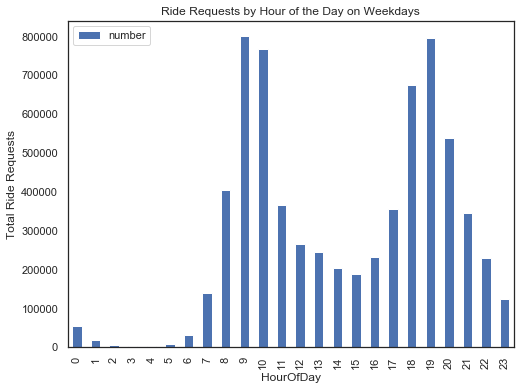

In [22]:
#Weekdays

hour = data[(data['DayOfWeekNum']==0) | (data['DayOfWeekNum']==1) | (data['DayOfWeekNum']==2) | (data['DayOfWeekNum']==3) | (data['DayOfWeekNum']==4)].pivot_table(index=['HourOfDay'],
                                  values='number',
                                  aggfunc='count')
hour.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Ride Requests')
plt.title('Ride Requests by Hour of the Day on Weekdays');

We observe office timings as peak hours on weekdays, 9th and 10th hour(Morning) and 18-20th hour(Evenings).


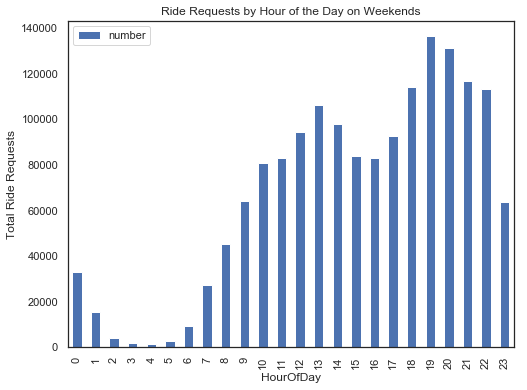

In [23]:
#Weekends

hour = data[(data['DayOfWeekNum']==5) | (data['DayOfWeekNum']==6)].pivot_table(index=['HourOfDay'],
                                  values='number',
                                  aggfunc='count')
hour.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Ride Requests')
plt.title('Ride Requests by Hour of the Day on Weekends');

We observe no office timings trend on weekends. Peak hours here look like lunch time, as people plan to go out on weekends, and ofcourse dinner timings(18-22nd hour). So Weekends and Weekdays do have different Trends in Hour of the Day.

Looks like we were right. So the Day of the Week does make a difference to our analysis. Next let's see how the Day of the Week Trend is.

# Day of the Week Trend


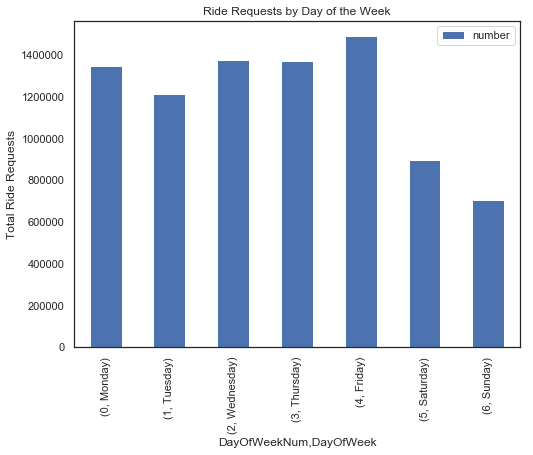

In [24]:
weekdays = data.pivot_table(index=['DayOfWeekNum','DayOfWeek'],
                                  values='number',
                                  aggfunc='count')
weekdays.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Ride Requests')
plt.title('Ride Requests by Day of the Week');

Looks like the Weekdays dominate the Weekends in terms of average number of ride requests! That is because regular riders going to office/college dominate the non-regular riders using the app only sometimes. So Day of the Week seems like an important feature! Seems like we could find further trends. Day of the Month, and Month in a Year should be explored too, so lets do that next.

# Month of the Year Trend

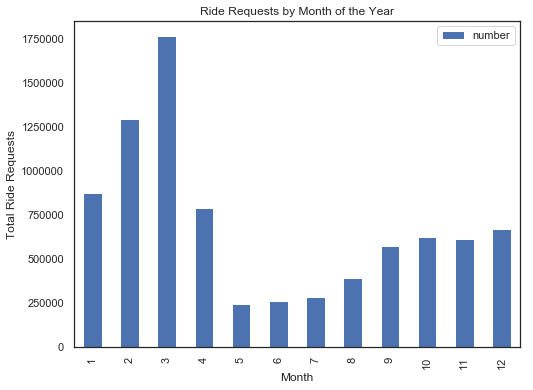

In [25]:
month = data.pivot_table(index=['Month'],
                                  values='number',
                                  aggfunc='count')
month.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Ride Requests')
plt.title('Ride Requests by Month of the Year');

We see that during May to July, the Ride Requests are low. This could be due to the fact that college students have a Summer Break during this time. In India, a lot of Rapido users are college students trying to find cheap transport. This trend tells us, that during Summer Break, ride requests go down, and slowly start picking up from August. Start of the Year seems to have a lot of ride requests. This is because Jan to March data is of 2019 and rest of the months data is of 2018. As Rapido has been growing, the trend seen could be solely because of growth of Rapido. Nevertheless, Month of the Year, is an important feature for our analysis. The Sesonality effect can be captured by this feature.

# Day of the Month Trend

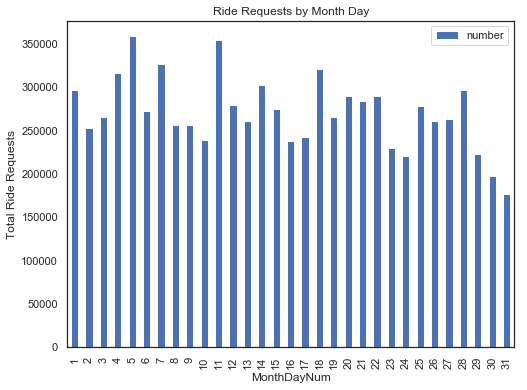

In [26]:
monthdays = data.pivot_table(index=['MonthDayNum'],
                                  values='number',
                                  aggfunc='count')
monthdays.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Ride Requests')
plt.title('Ride Requests by Month Day');

This plot doesnt give much of an insight about any trend as such. Hence Day of the Month Feature can be discarded.

In [27]:
data.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,HourOfDay,DayOfWeekNum,DayOfWeek,Month,MonthDayNum,geohash_pick,geohash_drop
0,2018-04-07 07:07:17,14626,12.313621,76.658195,12.287301,76.602280,7,5,Saturday,4,7,tdnw0,tdnmz
1,2018-04-07 07:32:27,85490,12.943947,77.560745,12.954014,77.543770,7,5,Saturday,4,7,tdr1s,tdr1s
2,2018-04-07 07:36:44,05408,12.899603,77.587300,12.934780,77.569950,7,5,Saturday,4,7,tdr1m,tdr1t
3,2018-04-07 07:38:00,58940,12.918229,77.607544,12.968971,77.636375,7,5,Saturday,4,7,tdr1q,tdr1y
4,2018-04-07 07:39:29,05408,12.899490,77.587270,12.934780,77.569950,7,5,Saturday,4,7,tdr1m,tdr1t


# DATA PREPARATION FOR MODELING

Lets prepare our data for modeling now! First I'd like to know if i can discard irrelevant clusters. Irrelevant clusters here would be clusters which are either very small in area or clusters which have number of ride requests/year lesser than a threshold. Lets take all clusters having number of ride requests/year >=5. Clusters below that threshold will not help us much in predicting a ride timing in that cluster.

In [28]:
data['geohash_pick'].value_counts()

tdr1w    1481044
tdr1q    1190834
tdr1t     844058
tdr1m     725584
tdr1v     615458
tdr1y     611740
tdr1x     453248
tdr1z     336613
tdr38     282956
tdr3b     245749
tdr1s     201176
tdr1r     190417
tdr1u     168737
tdr4n     152122
tdr4j     119920
tdr1p      92701
tdr4h      87356
tdr1k      60209
tdnw0      47027
tdr4p      42038
tdr1n      31566
tdr3c      28385
tdr1j      27964
tdnqp      26703
tdr1g      24420
tdr1e      23104
tdr45      21284
tdnmz      20974
tdr4m      19348
tdntb      14255
          ...   
tdpzd          1
tfcmc          1
tdr6h          1
tdnq0          1
tdpd9          1
tdsx8          1
ttqwe          1
tf2fw          1
tdr56          1
tdpd7          1
tsevk          1
tsvcw          1
tgfb7          1
ttmzu          1
tf347          1
tdr67          1
tu8kt          1
tdjy4          1
tsk7u          1
tdr78          1
tsjbt          1
tf34f          1
tstn6          1
ts5dv          1
tdrkz          1
tdqcd          1
ttncw          1
teg8p         

Threshold used here is 5, another number can be used to experiment with.

In [29]:
data = data.groupby('geohash_pick').filter(lambda x : len(x)>=5)

Our next step in data preparation will be converting the string values of GeoHash outputs to numerical values for the clusters, as our model will not accept strings. The following cell is a small piece of logic written to just do that, keeeping in mind the clusters in geohash_drop might overlap with the clusters in geohash_pick.

In [30]:
dic = {}
count = 0
l1 = []
for i in data['geohash_pick']:
    if i in dic:
        l1.append(dic[i])
    else:
        dic[i] = count
        l1.append(dic[i])
        count +=1
l2 = []
for i in data['geohash_drop']:
    if i in dic:
        l2.append(dic[i])
    else:
        dic[i] = count
        l2.append(dic[i])
        count +=1
        
data['geohash_pick'] = l1
data['geohash_drop'] = l2

Lets now visualize the clusters that GeoHash has formed.

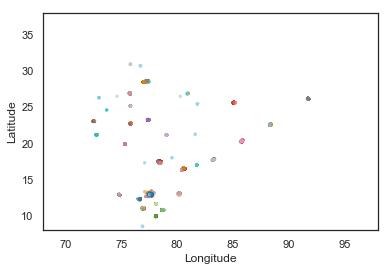

In [31]:
#Indias border latitudes and longitudes
long_border = (68, 98) 
lat_border = (8, 38)

#plotting the clusters made by the Geohash library to visualize how they look
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(data.pick_lng.values[:], data.pick_lat.values[:], s=10, lw=0,
           c=data.geohash_pick[:].values, cmap='tab20', alpha=0.2)
ax.set_xlim(long_border)
ax.set_ylim(lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

We see that there are clusters almost all over India.

In [32]:
#saving all the data into a csv, for future use, before dropping columns ahead
data.to_csv('rapido_data.csv',index=False)

Our next step in Data Prepapration would be to drop the columns not needed for further analysis. 

- All the information from Timestamp has been used, hence we can drop that safely. 
- Pickup and Drop latitude and longitude columns can be dropped as we've used these columns to create the Geohash features. 
- DayofWeek column has a correlation of 1 with DayofWeekNum, these 2 columns are essentially the same, hence DayofWeek can be dropped. 
- Lastly, MonthDayNum, didn't provide us any insight on Trend as seen during the Data Visualization Phase, hence this feature can be dropped too.

In [33]:
#dropping columns not required in the model
data.drop(['ts','pick_lat', 'pick_lng','drop_lat','drop_lng','DayOfWeek','MonthDayNum'], axis=1, inplace=True)

In [34]:
data.head()

,number,HourOfDay,DayOfWeekNum,Month,geohash_pick,geohash_drop
0,14626,7,5,4,0,27
1,85490,7,5,4,1,1
2,05408,7,5,4,2,8
3,58940,7,5,4,3,12
4,05408,7,5,4,2,8


Lastly, we'll define our target variable as Hour of the Day and try to predict this given the relevant Features in the model.

In [35]:
#Defining my target variable
y = data['HourOfDay']

In [36]:
#Defining my Features requried to predict my target variable
X = data.drop(['HourOfDay'],axis=1)

The train-test split used here is 0.8 : 0.2, which can be experimented with.

In [37]:
#Splitting my data into train and test set
X_train,X_cv,y_train,y_cv = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=True)

train = pd.concat([X_train,y_train],axis=1)
cv = pd.concat([X_cv,y_cv],axis=1)

# TRAINING OF MODEL AND VALIDATION


Intially, as the data is ordinal data(hours of the day are in order), an Ordinal Classifer was used. But that seemed to perform below acceptable standards. RandomForest, DecisionTree and KNeighbors seemed to do well, with DecisionTree performing the best. Other classifiers tested took either too much time to execute on such a large dataset, or performed below acceptable standards, hence only the 3 mentioned classifier results have been displayed.

In [38]:
#Trying different classifiers out to see which gives best results

#Performance metrics defined as a function
def performance_metrics(y_true,y_pred):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred,average = 'weighted')
    pre = precision_score(y_true, y_pred,average = 'weighted')
    f1 = f1_score(y_true, y_pred,average = 'weighted')
    
    return acc,rec,pre,f1

names = [
    #'OrdinalClassifier(DecisionTreeClassifier(max_depth=3))',
    'RandomForestClassifier',
    #'ExtraTreesClassifier',
    #'BaggingClassifier',
    #'GradientBoostingClassifier'
    #'AdaBoostClassifier',
    #'GaussianProcessClassifier',
    'KNeighborsClassifier',
    #'MLPClassifier'
    'DecisionTreeClassifier'
    #'ExtraTreeClassifier',
    #'SVC_RBF'
    #'LinearSVC',
    #'NuSVC',
    #'GaussianNB',
    #'QuadraticDiscriminantAnalysis'
]

classifiers = [
    #OrdinalClassifier(DecisionTreeClassifier(max_depth=3)),
    RandomForestClassifier(),
    #ExtraTreesClassifier(),
    #BaggingClassifier(),
    #GradientBoostingClassifier()
    #AdaBoostClassifier(),
    #GaussianProcessClassifier(),
    KNeighborsClassifier(),
    #MLPClassifier()
    DecisionTreeClassifier()
    #ExtraTreeClassifier(),
    #SVC(kernel = 'rbf')
    #LinearSVC(),
    #NuSVC(),
    #GaussianNB(),
    #QuadraticDiscriminantAnalysis()
]
displ = []
i = 0

listmodels =[]
for model in classifiers:
    model.fit(X_train,y_train)
    listmodels.append(model)
    em = []
    em.append(names[i])
    print(names[i])
    y_pred = model.predict(X_cv)
    y_pred=list(y_pred)
    acc,rec,pre,f1 = performance_metrics(y_cv,y_pred)
    em.append(acc)
    em.append(rec)
    em.append(pre)
    em.append(f1)
    displ.append(em)
    i = i + 1
    
output_class = pd.DataFrame(displ,columns=['Classifier Name','Accuracy','Recall','Precision','F1_Score'])
output_class

RandomForestClassifier
KNeighborsClassifier
DecisionTreeClassifier


,Classifier Name,Accuracy,Recall,Precision,F1_Score
0,RandomForestClassifier,0.616699,0.616699,0.614634,0.615413
1,KNeighborsClassifier,0.564779,0.564779,0.562717,0.561964
2,DecisionTreeClassifier,0.633498,0.633498,0.631882,0.632427


A point to note, is that instead of outputting just one Hour as prediction for every test point, we can output a distribution of probabilities. This will give a better understanding as to when there are multiple peak hours for a test data point, with high proabilities. For example, on a weekday, we can have peak Hour of ride requests in the morning (9th Hour) AND in the evening(20th Hour) for a particular test data point. Also morning could range from 9th Hour to 11th Hour maybe, and hence predicting a particular Hour would not justify our purpose then. Hence a probability distribution can be used based on the softmax results of a test data point, to better understand the Hourly Trend in a Day to predict a ride request. This was actually tried out for the Ordinal Classifier, but the Ordinal Classifier did not yield good results.
Decision Tree Classifier actually performed decently well. Given there are 24 classes, achieving an accuracy of 63.3% without any hyperparameter tuning, seems decent. This can be further improved using Hyperparameter tuning, or using ensemble techniques.

# Further Scope for Improvement and Experiments to Try Out

- Instead of using all days of Week as a feature, using Weekend/Weekday(binary feature) could be experimented with.
- Instead of using all months of the Year as a feature, using Seasonality(3-4 Seasons of the Year) could be experimented with.
- Hyperparameter tuning must be done, to further improve the results.
- Using Probability Distributions in the output to get a range of hours as output, instead of just one hour.
- Experimenting with Ensemble Models